# **NAVER, DAUM 가격데이터**
## **1 OHLC**
- 데이터 저장은 원본저장 후, **분석시 내용 적용하기**
- 415개가 아닌, 부족한 데이터를 갖는경우들이 많았음 (ETF 등등)
- **거래량 데이터가 튀는 부분이** 자주 있다 (늘었다가, 줄었다 해서 10분 등 끊어서 분석)

In [12]:
from krxstock.krx.daum import get_sectors
codes = get_sectors()['상장코드'].tolist()
len(codes)

get_sectors : 5.1702 sec


3033

In [13]:
import pandas
import datetime
import FinanceDataReader as fdr
from krxstock.krx.tools import webretries

@webretries(number_retries=3)
def get_price_ohlc(code:str, start:str=None, end:str=None) -> pandas.DataFrame:

    r"""Finance Data Reader 를 활용한 일간데이터 수집함수"""
    if start == None: start = datetime.date.today().strftime('%Y%m%d')
    if end == None:   end = datetime.date.today().strftime('%Y%m%d')
    # 날짜에 포함된 문자열 재정의
    for punct_string in list('.-/,'):
        if start.find(punct_string) != -1:
            start = "".join(list(map(lambda x : (f'{x:0>2}'), start.split(punct_string))))
        if end.find(punct_string) != -1:
            end = "".join(list(map(lambda x : (f'{x:0>2}'), end.split(punct_string))))
    return fdr.DataReader(code, start, end)

df = get_price_ohlc('373220', '1990/01/01')
df.head(3)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-01-27,597000,598000,450000,505000,15946992,NaN
2022-01-28,476000,483000,445000,450000,4559773,-0.108911
2022-02-03,458000,495500,441000,477000,2918435,0.060000


In [14]:
from tqdm import tqdm
items, errors = [], []
for code in tqdm(codes[::10]):
    df= get_price_ohlc(code)
    if df is not None:
        if len(df) > 0:
            df.insert(0,'Code',code)
            items.append(df)
    else: errors.append(code)

100%|█████████████████████████████████████████| 304/304 [01:34<00:00,  3.23it/s]


In [15]:
errors

[]

In [17]:
df = pandas.concat(items).head()

,Code,Open,High,Low,Close,Volume,Change
Date,,,,,,,
2022-03-14,373220,385000,385500,361500,363500,1983756,-0.070332
2022-03-14,122630,19100,19300,18915,19095,17264226,-0.002872
2022-03-14,025550,6600,7440,6460,6840,30053663,0.080569
2022-03-14,251340,4625,4775,4610,4755,31168038,0.026998
2022-03-14,068760,100000,109000,97500,99300,1133008,0.060897


In [13]:
import sys

In [32]:
def checking():
    def testing():
        name = super().__name__
        print(name,"\n", type(name))
#         print(super().__init__)
        print(sys._getframe().__name__) #.f_code.co_name
    print(testing)
#     print(checking.__name__)


checking()

<function checking.<locals>.testing at 0x7f8138a54940>


# **SAVED DATA 분석**
## **1 Initialized DataSet**
- 가격 데이터 (interval : 1m)
```python
warnings.simplefilter(action='ignore', category=FutureWarning)
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가

def matplot_font_adopt(font_list:list):
    fm_list = pd.Series([_.name for _ in fm.ttflist])
    font_check_list_valid = fm_list[fm_list.isin(font_list)].unique().tolist()
    print(f"found font list is : {font_check_list_valid}")
    return font_check_list_valid

font_check_list = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
font = matplot_font_adopt(font_check_list)
plt.style.use('seaborn')
plt.rc('font', family=font[-1]) # 폰트 적용하기

found font list is : ['NanumGothicCoding', 'NanumGothic', 'D2Coding']


In [2]:
# 기존에 CSV 저장된 내용 필터링 함수
import pandas as pd
from tqdm import tqdm
from glob import glob

def export_table(ticker:str='', *args, files:list) -> pd.DataFrame:
    result, column_names = [], {'market':'시장구분', 'name':'회사명','sectorName':'섹터구분',
        'symbolCode':'상장코드', 'tradePrice':'현재가격', 'changePrice':'가격변동', 
        'changeRate':'가격변동률', 'accTradeVolume':'거래량', 'accTradePrice':'거래금액', 
        'marketCap':'시가총액', 'foreignRatio':'외국인비율', 'datetime':'datetime'}
    # Export Ticker Data
    for file in tqdm(files):
        df = pd.read_csv(file)
        if ticker != '': result.append(df[df['symbolCode']==ticker])
        else: result.append(df.sort_values('accTradePrice', ascending=False))            
    # Post Processing 1 (DateTime pytz Converting)
    df = pd.concat(result).reset_index(drop=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    # df = df.set_index('datetime')
    # df = df.drop(['name','market'],axis=1)
    for column in ['tradePrice','changePrice','accTradeVolume','accTradePrice','marketCap']:
        df[column] = list(map(lambda x : int(x), df[column]))
    df['symbolCode'] = list(map(lambda x : x[1:], df['symbolCode']))
    df.columns = list(map(lambda x : column_names[x], df.columns)) # 한글 컬럼으로 변경
    df = df.set_index('datetime')
    df.index = df.index.tz_localize(tz='Asia/Seoul')
    filter_str = df.index[0].date().strftime('%Y-%m-%d') + " 09:00:00" # 9시 이후 데이터로 필터링
    return df[filter_str:]

## **1 Daily Price**
- 데이터 저장은 원본저장 후, **분석시 내용 적용하기**
- 415개가 아닌, 부족한 데이터를 갖는경우들이 많았음 (ETF 등등)
- **거래량 데이터가 튀는 부분이** 자주 있다 (늘었다가, 줄었다 해서 10분 등 끊어서 분석)

In [5]:
ticker = '' # 'A097870'
files = sorted(glob('./data/stock/*.csv'))
df = export_table(ticker=ticker, files=files)
df.head(2)

100%|████████████████████████████████████████| 451/451 [00:02<00:00, 174.51it/s]


,회사명,상장코드,시장구분,현재가격,가격변동,가격변동률,거래량,거래금액,시가총액,외국인비율
datetime,,,,,,,,,,
2022-03-04 09:00:00+09:00,넥슨지티,041140,KOSDAQ,23900,0,0.0,54328,1298439200,845422395800,1.21
2022-03-04 09:00:00+09:00,넷게임즈,225570,KOSDAQ,22900,0,0.0,39474,903954600,660826834300,0.96


<AxesSubplot:xlabel='datetime'>

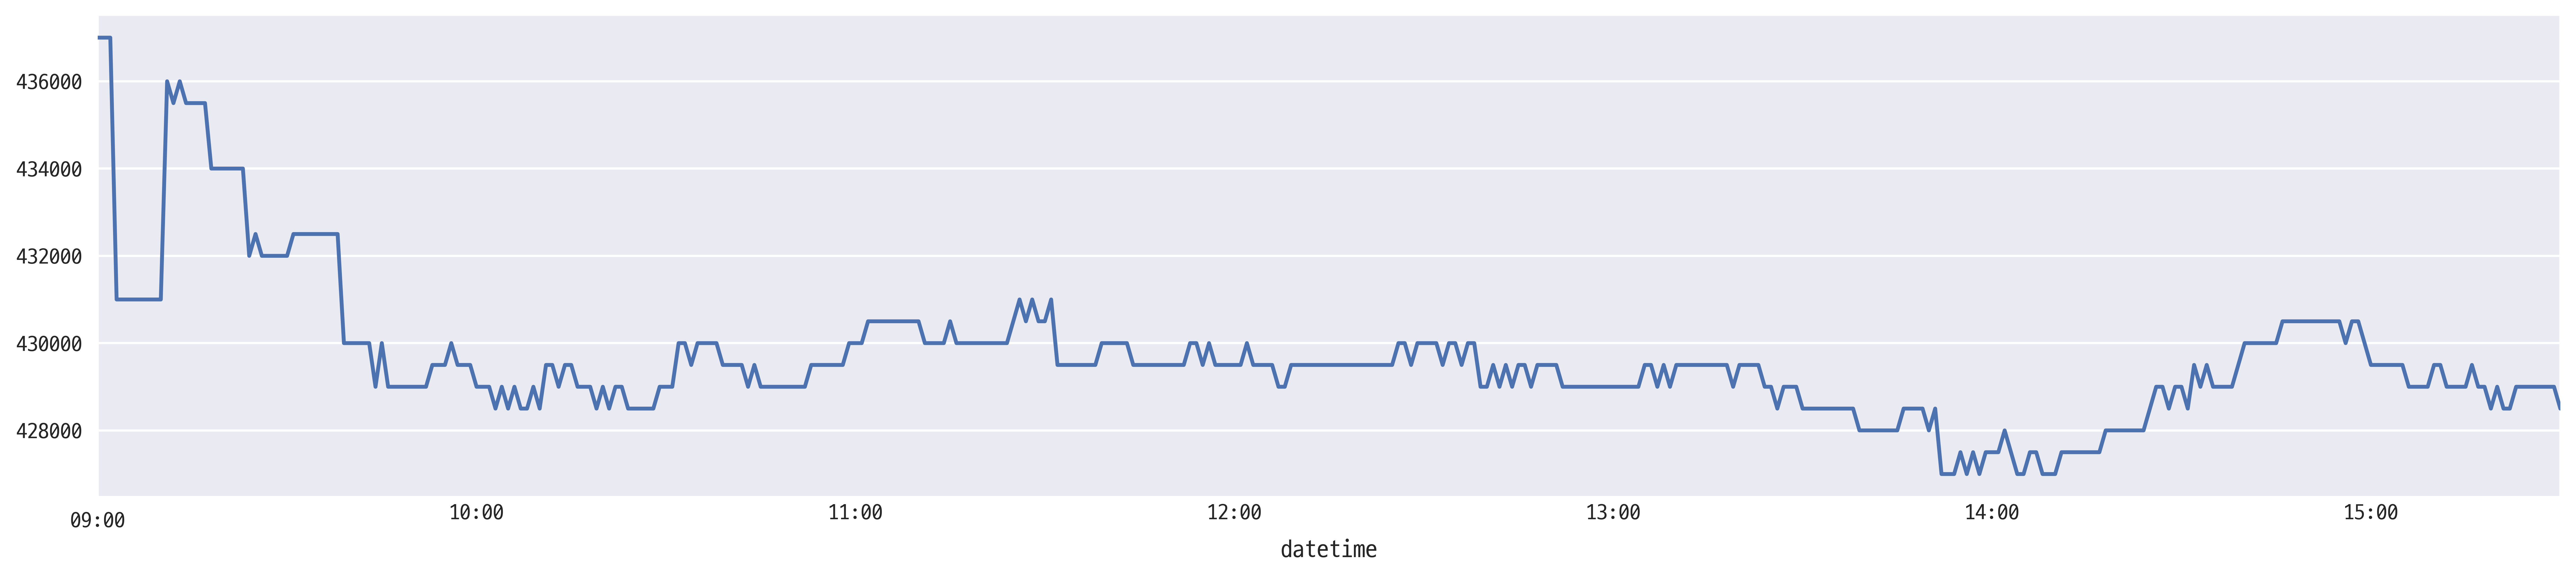

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (20.0, 4.0)
df[df['회사명']=="LG에너지솔루션"]["2022-03-04 09:00:00":]['현재가격'].plot()

In [5]:
df[df['회사명']=="LG에너지솔루션"]["2022-03-04 09:00:00":].head(3)

,회사명,상장코드,시장구분,현재가격,가격변동,가격변동률,거래량,거래금액,시가총액,외국인비율
datetime,,,,,,,,,,
2022-03-04 09:00:00+09:00,LG에너지솔루션,373220,KOSPI,437000,0,0.0,623,272251000,102258000000000,3.57
2022-03-04 09:01:00+09:00,LG에너지솔루션,373220,KOSPI,437000,0,0.0,623,272251000,102258000000000,3.57
2022-03-04 09:02:00+09:00,LG에너지솔루션,373220,KOSPI,437000,0,0.0,623,272251000,102258000000000,3.57


In [4]:
import time
import termcolor  # termcolor.COLORS
from tqdm import tqdm
from krxstock.krx.tools import webretries

@webretries(number_retries=3)
def get_prices(code, date_string):
    return fdr.DataReader(code, date_string)

datetime_string = '20220308'
items, errors = [], []
for code in tqdm(code_series):
    df= get_prices(code, datetime_string)
    df.insert(0,'Code',code)
    items.append(df)

100%|█████████████████████████████████████████| 422/422 [00:45<00:00,  9.36it/s]


In [3]:
df = fdr.DataReader('510007','2022.2')

In [4]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-03,26255,26625,26195,26265,6477,0.044126
2022-02-04,26265,26880,26260,26345,8591,0.003046
2022-02-07,27000,27810,26345,27240,13218,0.033972
2022-02-08,27985,27985,27360,27360,10460,0.004405
2022-02-09,26210,26750,26040,26695,9708,-0.024306
2022-02-10,27310,27980,27295,27915,12306,0.045701
2022-02-11,26630,27850,26325,27235,7536,-0.024360
2022-02-14,26600,28680,26595,27955,13608,0.026437
2022-02-15,27360,27855,26290,26845,7865,-0.039707


<AxesSubplot:xlabel='Date'>

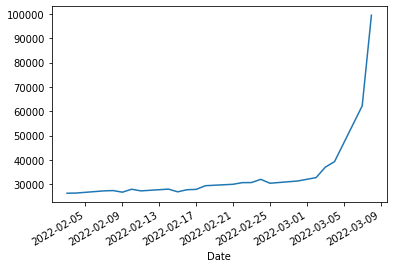

In [6]:
df['Close'].plot()

In [ ]:
from scipy.interpolate import make_interp_spline
make_interp_spline(x.index, x.values)

In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

# Dataset
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([20, 30, 5, 12, 39, 48, 50, 3])

X_Y_Spline = make_interp_spline(x, y)

# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## **1 Price History 1h**

In [ ]:
def get_dataframe(file):
    r"""pickle to DataFrame"""
    df = pd.read_pickle(file)
    df.columns = ['date_time'] + df.columns.tolist()[1:]
    df.date_time = pd.DatetimeIndex(df.date_time).tz_convert('Asia/Seoul')
    df = df.sort_values(['yahoo_code', 'date_time']).reset_index(drop=True)
    df = df.drop(['Adj Close'], axis=1)
    return df

    # df = df.set_index('date_time')
    for column in ['Open','High','Low','Close','Volume']:
        df[column] = list(map(lambda x : int(x), df[column]))
    
    df['yahoo_code'] = list(map(lambda x : x.split('.')[0], df['yahoo_code']))
    df = df.sort_values(['date_time', 'yahoo_code']).reset_index(drop=True)
    df = df.set_index('date_time')
    return df

## **2 Load Saved DataSet**
```python
import re
tokenizer = re.compile('[\w\d]*1h[.\w\d]*')
```

In [ ]:
import pandas as pd
from glob import glob
files = sorted(glob('./data/price/*.pkl'))
files = list(filter(lambda x : x.find('1h') != -1, files))
files

In [ ]:
df = get_dataframe(files[0])
df.head(3)

In [ ]:
import pytz
from datetime import datetime, timedelta

seoul = pytz.timezone("Asia/Seoul")
time_check = datetime(2020, 2, 18, 9, 0, 0)
df[(df.yahoo_code == '000020.KS') & (df.date_time == seoul.localize(time_check))]

## **[3 Fillna Nan](https://www.geeksforgeeks.org/how-to-filter-dataframe-rows-based-on-the-date-in-pandas/)**
> **.between()** 으로 구간을 정해서 필터링 적용

1. 이후부터 거래정지로 자료가 없을 때
1. 해당 일자만 자료가 없을 때
1. 전날 유효값이 있는지
1. 당일날 유효값이 몇개가 있는지 확인하기

In [ ]:
# 'dict','list','series','split','records','index'
from datetime import timedelta
df_nan = df[df.Open.isna()].reset_index(drop=True).iloc[:,:2].copy()
print(df_nan.shape)

nan_list = df_nan.to_dict(orient='records')
for data in nan_list:
    code = data['yahoo_code']
    check_day = data['date_time'].date()
    df_check = df[(df.yahoo_code == code) & (
        df.date_time.between(
            check_day.strftime('%Y-%m-%d'), 
            (check_day + timedelta(days=1)).strftime('%Y-%m-%d'))
    )]
    # print(f"{code} {check_day} length: {df_check.shape[0]}")
    if df_check.shape[0] != 1:
        print(f"{code} {check_day} length: {df_check.shape[0]}")

In [ ]:
df[(df.yahoo_code == '172580.KS') & (df.date_time.between('2019-11-14','2019-11-15'))]

In [ ]:
df[(df.yahoo_code == '005930.KS') & (df.date_time.between('2019-11-06','2019-11-15'))]

## DateTime
- https://www.nasdaq.com/market-activity/stocks/aapl
- [KRX INFO](http://data.krx.co.kr/contents/MDC/MAIN/main/index.cmd)
- [마이패스트스탁](https://myfaststock.com/)
- [WSJ 기업찾기](https://www.wsj.com/market-data/quotes/KR/033110/company-people)
- https://www.geeksforgeeks.org/python-datetime-to-integer-timestamp/
- https://www.codegrepper.com/code-examples/python/convert+timestamp+to+string+python
- https://www.programiz.com/python-programming/datetime/strftime

In [ ]:
import pytz
import pickle
from functools import reduce
from krxstock.daum import get_sectors

seoul = pytz.timezone("Asia/Seoul")
df = get_sectors(raw=False, filter=False)
df.symbolCode = list(map(lambda x : x[1:], df.symbolCode))
df.changeRate = list(map(lambda x : round(x*100, 2), df.changeRate))

# SQL 1.DateTime 2.Integer Field 저장을 위한 타입변환
df.datetime   = list(map(lambda x : seoul.localize(x), df.datetime.tolist()))
columns = ['tradePrice','changePrice','accTradeVolume','accTradePrice','marketCap']
for _ in columns:
    df[_] = list(map(lambda x : int(x), df[_]))
    
# import pickle
# dict_krx = df.set_index('symbolCode').to_dict(orient='index')
# with open('krx_price.pkl', 'wb') as handle:
#     pickle.dump(dict_krx, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('krx_price.pkl', 'rb') as handle:
#     data = pickle.load(handle)
# data['005930']
df.head(3)

# **Future**
코스피 선물 200 데이터 수집기 `Investing.com`

In [ ]:
# Investing.com
# 8874
from momukji.investing import get_price
df = get_price()
df.tail(3)

In [ ]:
# Investing.com
# 8874
from momukji.investing import kospi200
df = kospi200(symbol=")
df.tail(3)

# **Traders**
- 거래원 column 또는 구분자를 미리 정하고 작업하는데 문제가 발생
- 차후에는 ERD 없이 작업을 한 뒤, 완성시 ERD 적용하기 (작업속도 향상)

In [ ]:
from momukji import daum
df = daum.get_future()
print(", ".join(df.columns.tolist())) # df.head(2) sum(df.iloc[0, 1:])
df.iloc[0, 1:]

In [ ]:
df = daum.get_market(page=1)
# print(", ".join(df.columns.tolist()))
df.iloc[0, 2:]

In [ ]:
_ = [
    'INDIVIDUAL':['INDIVIDUAL'],# 개인
    'FOREIGN',             # 외국인
    'FINANCIAL_INVESTOR',  # 금융투자
    'INSURANCE_COMPANIES', # 보험
    'PRIVATE_EQUITY_FUND', # 사모펀드
    'MUTUAL_FUND',         # 투자신탁
    'BANK',                # 은행
    'PENSION_FUND',        # 국민연금
    'PUBLIC_INSTITUTION'   # 국가
    'ETC_CORPORATION',     # 기타_법인
    'ETC_FINANCIAL_INSTITUTION', # 기타_금융
    'ETC_FOREIGN',         # 기타_외국인
]

In [ ]:
# future
_ = [
    'privateSettlement',         # 개인
    'foreignSettlement',         # 외국인
    'institutionalSettlement',   # 기관합계 (제외할 것)
    'financialInvestment',       # 금융투자
    'insuranceInvestment',       # 보험 
    'trustInvestment',           # 투자신탁
    'bankInvestment',            # 은행
    'pensionFundInvestment'      # 연기금
    'etc_Investment',            # 기타_금융
    'etc_CorporationSettlement', # 기타_법인
]

In [ ]:
_ = [
    'INDIVIDUAL',          # 개인
    'FOREIGN',             # 외국인
    'FINANCIAL_INVESTOR',  # 금융투자
    'INSURANCE_COMPANIES', # 보험
    'PRIVATE_EQUITY_FUND', # 사모펀드
    'MUTUAL_FUND',         # 투자신탁
    'BANK',                # 은행
    'PENSION_FUND',        # 국민연금
    'PUBLIC_INSTITUTION'   # 국가
    'ETC_CORPORATION',     # 기타_법인
    'ETC_FINANCIAL_INSTITUTION', # 기타_금융
    'ETC_FOREIGN',         # 기타_외국인
]

In [ ]:
_ = [
    '개인',
    '외국인',
    '금융투자',
    '보험',
    '투신',
    '사모',
    '은행',
    '연기금',
    '기타금융',
    '기타법인',
    '기타외국인',
    '전체'
]

In [ ]:
from pykrx import stock as pystock
df = pystock.get_market_trading_value_by_date("20210915", "20211002", "005930", detail=True)
df.columns.tolist()

In [ ]:
sum(df.reset_index().iloc[1,1:])

In [ ]:
from tqdm import tqdm
from momukji.daum import get_future

In [ ]:
df_list = [get_future(page) for page in tqdm(range(1,43))]

In [ ]:
from tqdm import tqdm
from momukji import daum
df = daum.get_future()
# df_list = [daum.get_future(page) for page in tqdm(range(1,43))]
df.head(3)

In [ ]:
df.columns.tolist()

In [ ]:
from momukji.daum import get_market
df_market = get_market()
df_market.columns.tolist()

In [ ]:
from momukji.book import get_book
df = get_book('안티프래질')
df.loc[0,'infos']

# **Volumes**
## **1 코스피, 코스닥 투자자 거래 데이터 수집**

In [ ]:
from momukji.daum import get_sectors, get_market_pages, get_market

In [ ]:
# from momukji import stock
import time
from momukji.daum import get_market_pages
_ = get_market_pages("KOSPI", save=True, folder='data')
_ = get_market_pages("KOSDAQ", save=True, folder='data')

In [ ]:
# from FinanceDataReader.investing.listing import InvestingEtfListing
import requests
import pandas as pd

def kospi_future(page:str=260):
    url = f"https://finance.daum.net/api/future/KR4101RC0000/times?pagination=true&perPage=100&page={page}"
    headers = {
        "Accept":"application/json, text/javascript, */*; q=0.01",
        "Accept-Encoding":"gzip, deflate, br",
        "Host":"finance.daum.net",
        "Referer":"https://finance.daum.net/domestic/futures",
        "User-Agent":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0",
        "X-Requested-With":"XMLHttpRequest"
    }
    response = requests.get(url, headers=headers)
    data = response.json()['data']
    if len(data) > 0:
        return pd.DataFrame(data)
    else:
        return None


In [ ]:
df_list = []
import time
from tqdm import tqdm
for page in tqdm(range(1, 261)):
    df = kospi_future(page)
    if df is not None:
        df_list.append(df)
    else:
        pass
    if page % 50 == 49:
        time.sleep(1)
    else:
        time.sleep(.3)

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def kospi200_future(start=datetime(2000, 1, 1), end=datetime(2022, 1, 1)):
    r"""Kospi 200 선물데이터 수집기"""
    symbol="8987"
    url = f"https://tvc4.investing.com/7ddd7a93ddd39e4d7ca650e9e6ef7cee/1632977441/18/18/88/"
    url_tail = f"history?symbol={symbol}&resolution=D&from={int(start.timestamp())}&to={int(end.timestamp())}"
    headers = {
        "Host":"tvc4.investing.com",
        "Origin":"https://tvc-invdn-com.investing.com",
        "Referer":"https://tvc-invdn-com.investing.com/",
        "TE":"Trailers",
        "User-Agent":"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0"
    }
    response = requests.get(url+url_tail, headers=headers)
    df = pd.DataFrame(response.json())
    df.t = list(map(lambda x : datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S"), df.t))
    df = df.rename(columns={'t':'date_time', 'c':'close', 'o':'open','h':'high', 'l':'low', 'v':'volume'})
    df = df.drop(['vo','s'], axis=1)
    return df

In [ ]:
# 종가 시간변화 데이터 저장하기
from momukji import stock
# [stock.get_daum_market(market=market, save=True, folder="data")  for market in ["KOSPI", "KOSDAQ"]]
df = stock.get_daum(filter=True)
df.head(3)

In [ ]:
import FinanceDataReader as fdr
fdr.DataReader('011200').tail(3)

# **공매도 대차 데이터 (Loan / Short)**
## **1 Krx 공매도 데이터**
[PyKRX 공매도 데이터 수집함수](https://freesoft.dev/program/161520254)

In [ ]:
from pykrx import stock as pystock
df_ticker = pystock.get_shorting_balance_by_date("20200101", "20220101", "011200") # Ticker 단위
df_ticker.tail(2)

In [ ]:
# Initialized Matplotlib
import matplotlib.pyplot as plt
from momukji import get_matplot_font
plt.rc('font', family=get_matplot_font())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (20.0, 3.0)
df_ticker.loc[:, '공매도잔고'].plot()

## **2 Krx 공매도 데이터 내용확인**

In [ ]:
from pykrx import stock as pystock
# df = pystock.get_shorting_balance_by_date("20160701", "20220101", "011200") # Ticker 단위
df = pystock.get_shorting_balance_by_date("20160701", "20220101", "950210") # Ticker 단위
df = df.reset_index().loc[:, ['날짜', '공매도잔고', '비중']]
df.head(3)

In [ ]:
df = pystock.get_shorting_status_by_date("20200101", "20220101", "011200")
df.tail(3)

In [ ]:
df = pystock.get_shorting_volume_by_ticker("20181212",market="KOSDAQ")
print(df)

In [ ]:
# df = pystock.get_shorting_balance_by_ticker("20160701", market="KOSDAQ")
df = pystock.get_shorting_balance_by_ticker("20160601", market="KOSDAQ")
len(df)

## **3 Krx 공매도 데이터 수집기**

In [ ]:
# from momukji import darts
# df = darts.get_code(detail="fss", filter=True)
# codes = df.stock_code.tolist()

# from tqdm import tqdm
# from time import sleep
# from pykrx.stock import get_shorting_balance_by_date as short
# result = []
# for no, code in tqdm(enumerate(codes)):
#     df = short("20160701", "20220101", code)
#     if len(df)>0:
#         df = df.reset_index()
#         df.insert(1,'code', code)
#         result.append(df)
#     del df
    
#     # Adding delayTime
#     if no % 100 == 9:
#         sleep(4)
#     else:
#         sleep(.5)
    
# import pandas as pd
# df = pd.concat(result)
# df.to_pickle('krx_short.pkl')

In [ ]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')
fig = go.Figure(data = [go.Candlestick(x=df['Date'],
                open = df['AAPL.Open'],
                high = df['AAPL.High'],
                low = df['AAPL.Low'],
                close = df['AAPL.Close'])])
fig.show()

## **2 1분 가격데이터 수집기**

In [ ]:
%%time
interval = '5m'
# from urllib3.exceptions import NewConnectionError
import pandas as pd
import datetime, time
from tqdm import tqdm
from momukji.daum import get_sectors
from momukji.yahoo import get_yahoo

df = get_sectors()
codes = df.yahoo_code.tolist()
str_today = datetime.datetime.today().strftime('%Y-%m-%d')
df_result, errors = [], []
for no, code in tqdm(enumerate(codes)):
    df = get_yahoo(code, interval=interval, display=False)
    if df is not False:
        df_result.append(df)
        del df
    else:
        errors.append(code)
    if no % 50 == 49:
        time.sleep(5)
    elif no % 500 == 499:
        time.sleep(15)
    else:
        time.sleep(1)

print("processing is done")
df = pd.concat(df_result).reset_index()
df.to_pickle(f'price_{interval}_{str_today}.pkl')
if len(errors)>0:
    pd.Series(errors).to_pickle(f'price_{interval}_{str_today}_errors.pkl')
df.tail(3)

# **Html Requests**
https://github.com/psf/requests-html/issues/294#issuecomment-585661621

In [ ]:
url = "https://m.finance.daum.net/quotes/A011200/influential_investors/trader"
from requests_html import AsyncHTMLSession
asession = AsyncHTMLSession()
response = await asession.get(url)
await response.html.arender()

In [ ]:
resp = response.html.raw_html
with open("test.html", "w") as f:
    f.write(resp.decode('utf-8'))

In [ ]:
import pandas as pd
data = [None, 'a', 'sa', None]
data = pd.Series(data)
data == None